This Notebook is showing what you can do with simple linear regression techniques. The data is obtained from a website called koopwoningen using a basic parser.

In [236]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from scipy import stats

Read the data from the file, the first row of the file contains the headers.

*Note to self* If the first line contains a space after a comma, the name of the header also contains the space

In [268]:
house = pd.read_csv('2_all_houses.txt')

In [238]:
house

,NumberOfRooms,SquareFootage,Price,YearBuilt,Type,Address,City
0,3,61,284500,1983,Appartement,Nes 96,Pijnacker
1,4,104,375000,1983,Woonhuis,Roggeakker 23,Pijnacker
2,4,277,1075000,2006,Woonhuis,Katwijkerlaan 119,Pijnacker
3,5,101,450000,2002,Woonhuis,Rodenrijseweg 547,Berkel en Rodenrijs
4,6,140,600000,2002,Woonhuis,Gouden Harplaan 27,Berkel en Rodenrijs
...,...,...,...,...,...,...,...
368,9,280,1695000,1985,Woonhuis,Ringvaartweg 211,Rotterdam
369,4,111,730000,1985,Appartement,Baan 54 S,Rotterdam
370,3,101,725000,1985,Appartement,Baan 50 M,Rotterdam
371,4,140,969000,1985,Appartement,Baan 56 C,Rotterdam


We have to do some data cleaning. Remove rediculously expensive houses, and house with to many rooms. Also remove the houses without a price, as they do not contribute anything

In [271]:
# An outlier of a dataset is defined as a value that is more than 3 standard deviations from the mean.
house = house[(np.abs(stats.zscore(house["Price"])) < 3)]
house = house[(np.abs(stats.zscore(house["NumberOfRooms"])) < 3)]
house = house[house["Price"] > 0]

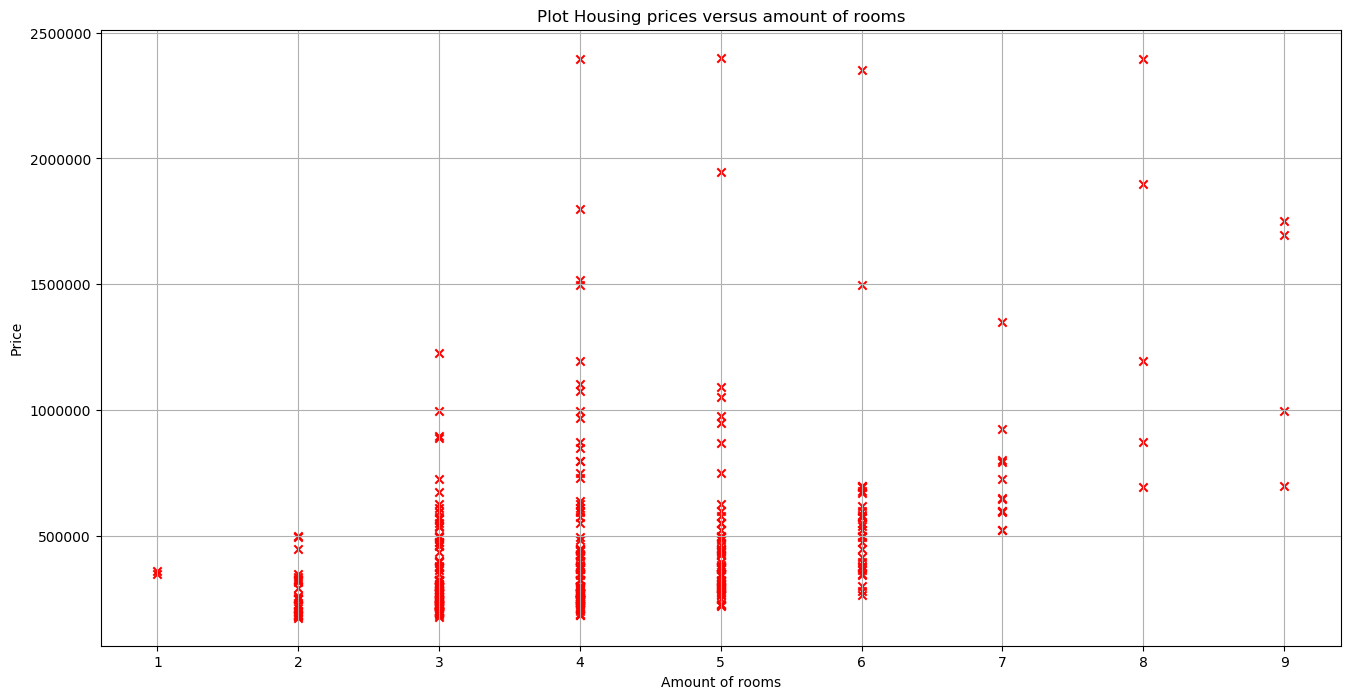

In [272]:
tick_spacing = 1
fig, ax = plt.subplots(1,1)

ax.scatter(house["NumberOfRooms"], house["Price"], c='r',marker='x')
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.title('Plot Housing prices versus amount of rooms')
plt.ylabel('Price')
plt.xlabel('Amount of rooms')
plt.rcParams["figure.figsize"] = (16,8)
plt.grid()
plt.show()

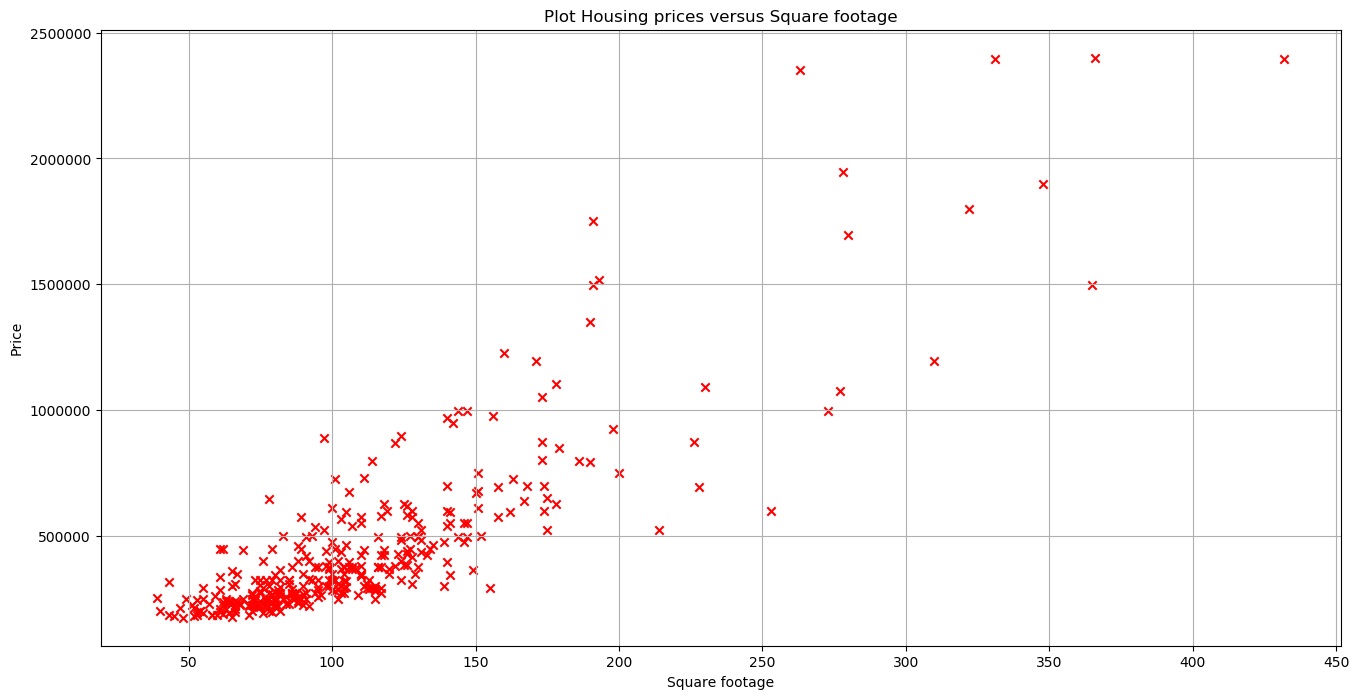

In [273]:
tick_spacing = 50
fig, ax = plt.subplots(1,1)

ax.scatter(house["SquareFootage"], house["Price"], c='r',marker='x')
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.title('Plot Housing prices versus Square footage')
plt.ylabel('Price')
plt.xlabel('Square footage')
plt.rcParams["figure.figsize"] = (1,8)
plt.grid()
plt.show()

In [242]:
import sys
!{sys.executable} -m pip install turicreate

In [243]:
import turicreate as tc

In [274]:
data = tc.SFrame(house)

In [245]:
data

NumberOfRooms,SquareFootage,Price,YearBuilt,Type,Address,City
3,61,284500,1983,Appartement,Nes 96,Pijnacker
4,104,375000,1983,Woonhuis,Roggeakker 23,Pijnacker
4,277,1075000,2006,Woonhuis,Katwijkerlaan 119,Pijnacker
5,101,450000,2002,Woonhuis,Rodenrijseweg 547,Berkel en Rodenrijs
6,140,600000,2002,Woonhuis,Gouden Harplaan 27,Berkel en Rodenrijs
5,104,350000,2002,Woonhuis,Wilhelminastraat 98,Berkel en Rodenrijs
6,128,575000,2002,Woonhuis,Stationssingel 6,Berkel en Rodenrijs
5,128,600000,1980,Woonhuis,Rozendaallaan 7,Berkel en Rodenrijs
6,140,700000,1980,Woonhuis,Cissy vanMarxveldtplantsoen 9 ...,Berkel en Rodenrijs
5,97,525000,1980,Woonhuis,Rodenrijseweg 549,Berkel en Rodenrijs


In [275]:
# Sometimes SFrame objects are loaded lazy, showing data will than be empty, materialize will fix this and load the data.
data.materialize()

In [358]:
model_sf = tc.linear_regression.create(data_filtered, features=['SquareFootage','NumberOfRooms','YearBuilt'],target='Price')

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Linear regression:

--------------------------------------------------------

Number of examples          : 302

Number of features          : 3

Number of unpacked features : 3

Number of coefficients    : 4

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+

| Iteration | Passes   | Elapsed Time | Training Max Error | Validation Max Error | Training Root-Mean-Square Error | Validation Root-Mean-Square Error |

+-----------+----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+

| 1         | 2        | 0.014637     | 495442.545683      | 136654.324128        | 120068.697805                   | 62047.019342                      |

+-----------+----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+

SUCCESS: Optimal solution found.

In [278]:
model_nr = tc.linear_regression.create(data_filtered, features=['NumberOfRooms'],target='Price')

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Linear regression:

--------------------------------------------------------

Number of examples          : 302

Number of features          : 1

Number of unpacked features : 1

Number of coefficients    : 2

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+

| Iteration | Passes   | Elapsed Time | Training Max Error | Validation Max Error | Training Root-Mean-Square Error | Validation Root-Mean-Square Error |

+-----------+----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+

| 1         | 2        | 0.000799     | 667718.956522      | 230140.571108        | 165297.120211                   | 110645.326065                     |

+-----------+----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+

SUCCESS: Optimal solution found.

In [279]:
new_house = tc.SFrame({'SquareFootage':[99], 'NumberOfRooms':[3], 'Type':["Appartement"], 'YearBuilt':[1999]})
print("Price predicted by Square Footage: {:.0f}".format(model_sf.predict(new_house)[0]))
print("Price predicted by Square Footage: {:.0f}".format(model_nr.predict(new_house)[0]))

Price predicted by Square Footage: 380337
Price predicted by Square Footage: 327281


In [250]:
model_nr.summary()

Class                          : LinearRegression

Schema
------
Number of coefficients         : 2
Number of examples             : 302
Number of feature columns      : 1
Number of unpacked features    : 1

Hyperparameters
---------------
L1 penalty                     : 0.0
L2 penalty                     : 0.01

Training Summary
----------------
Solver                         : newton
Solver iterations              : 1
Solver status                  : SUCCESS: Optimal solution found.
Training time (sec)            : 0.0032

Settings
--------
Residual sum of squares        : 8243886890524.305
Training RMSE                  : 165219.9707

Highest Positive Coefficients
-----------------------------
(intercept)                    : 150273.0209
NumberOfRooms                  : 59535.56

Lowest Negative Coefficients
----------------------------
No Negative Coefficients       : 



In [347]:
model_sf.summary()

Class                          : LinearRegression

Schema
------
Number of coefficients         : 13
Number of examples             : 302
Number of feature columns      : 5
Number of unpacked features    : 5

Hyperparameters
---------------
L1 penalty                     : 0.0
L2 penalty                     : 0.01

Training Summary
----------------
Solver                         : newton
Solver iterations              : 1
Solver status                  : SUCCESS: Optimal solution found.
Training time (sec)            : 0.0148

Settings
--------
Residual sum of squares        : 3949559983554.9414
Training RMSE                  : 114359.1413

Highest Positive Coefficients
-----------------------------
City[Berkel en Rodenrijs]      : 56283.7082
SquareFootage                  : 4509.9181
City[Rotterdam]                : 367.7798
YearBuilt                      : 245.6316

Lowest Negative Coefficients
----------------------------
(intercept)                    : -431302.7111
City[Zoetermeer

In [280]:
# https://www.geeksforgeeks.org/polynomial-regression-using-turicreate/
def createSframe(inputs, pol_degree):
    datapoints = tc.SFrame({'x1': inputs})
    for degree in range(2, pol_degree+1):
        datapoints[f'x{degree}'] = datapoints[f'x{degree-1}']*datapoints['x1']
    return datapoints

In [281]:
# We create more polynomial input (20), later we choose the amount that we want to use.
data_points_sf = createSframe(data_filtered["SquareFootage"], 20)
data_points_sf['y'] = data_filtered["Price"]
data_points_nr = createSframe(data_filtered["NumberOfRooms"], 20)
data_points_nr['y'] = data_filtered["Price"]

In [254]:
data_points_sf

x1,x2,x3,x4,x5,x6,x7,x8
61,3721,226981,13845841,844596301,51520374361,3142742836021,191707312997281
104,10816,1124864,116985856,12166529024,1265319018496,131593177923584,13685690504052736
101,10201,1030301,104060401,10510100501,1061520150601,107213535210701,10828567056280801
140,19600,2744000,384160000,53782400000,7529536000000,1054135040000000,147578905600000000
104,10816,1124864,116985856,12166529024,1265319018496,131593177923584,13685690504052736
128,16384,2097152,268435456,34359738368,4398046511104,562949953421312,72057594037927936
128,16384,2097152,268435456,34359738368,4398046511104,562949953421312,72057594037927936
140,19600,2744000,384160000,53782400000,7529536000000,1054135040000000,147578905600000000
97,9409,912673,88529281,8587340257,832972004929,80798284478113,7837433594376961
152,23104,3511808,533794816,81136812032,12332795428864,1874584905187328,284936905588473856


In [368]:
# Be ware, the polynomial power must be lower than the one we created fields for above
polynomial_power = 8
features = [f'x{i}' for i in range(1, polynomial_power)]
poly_model_sf = tc.linear_regression.create(data_points_sf, features=features, target='y')
poly_model_nr = tc.linear_regression.create(data_points_nr, features=features, target='y')

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Linear regression:

--------------------------------------------------------

Number of examples          : 302

Number of features          : 7

Number of unpacked features : 7

Number of coefficients    : 8

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+

| Iteration | Passes   | Elapsed Time | Training Max Error | Validation Max Error | Training Root-Mean-Square Error | Validation Root-Mean-Square Error |

+-----------+----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+

| 1         | 2        | 0.003898     | 533860.387863      | 128181.841378        | 119702.258353                   | 63294.424067                      |

+-----------+----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+

SUCCESS: Optimal solution found.

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Linear regression:

--------------------------------------------------------

Number of examples          : 302

Number of features          : 7

Number of unpacked features : 7

Number of coefficients    : 8

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+

| Iteration | Passes   | Elapsed Time | Training Max Error | Validation Max Error | Training Root-Mean-Square Error | Validation Root-Mean-Square Error |

+-----------+----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+

| 1         | 2        | 0.001296     | 660206.982271      | 290206.982271        | 161447.832796                   | 129870.285805                     |

+-----------+----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+

SUCCESS: Optimal solution found.

In [256]:
poly_model_sf.summary()

Class                          : LinearRegression

Schema
------
Number of coefficients         : 8
Number of examples             : 302
Number of feature columns      : 7
Number of unpacked features    : 7

Hyperparameters
---------------
L1 penalty                     : 0.0
L2 penalty                     : 0.01

Training Summary
----------------
Solver                         : newton
Solver iterations              : 1
Solver status                  : SUCCESS: Optimal solution found.
Training time (sec)            : 0.0088

Settings
--------
Residual sum of squares        : 4201952699212.3936
Training RMSE                  : 117956.5626

Highest Positive Coefficients
-----------------------------
(intercept)                    : 234217.8589
x2                             : 10.2183
x3                             : 0.1771
x4                             : 0.0002
x7                             : 0.0

Lowest Negative Coefficients
----------------------------
x1                            

In [283]:
def predict_price_linear_num_rooms(num_rooms):
    predicted_prices = []
    for n in num_rooms:
        new_house = tc.SFrame({'NumberOfRooms':[n]})
        predicted_prices.append(model_nr.predict(new_house))
    return predicted_prices

def predict_price_linear_square_footage(square_footage):
    predicted_prices = []
    for n in square_footage:
        new_house = tc.SFrame({'SquareFootage':[n]})
        predicted_prices.append(model_sf.predict(new_house))
    return predicted_prices

def predict_price_poly(x, power, use_model):
    predicted_prices = []
    for n in x:
        new_house = createSframe([n], power)
        predicted_prices.append(use_model.predict(new_house))
    return predicted_prices

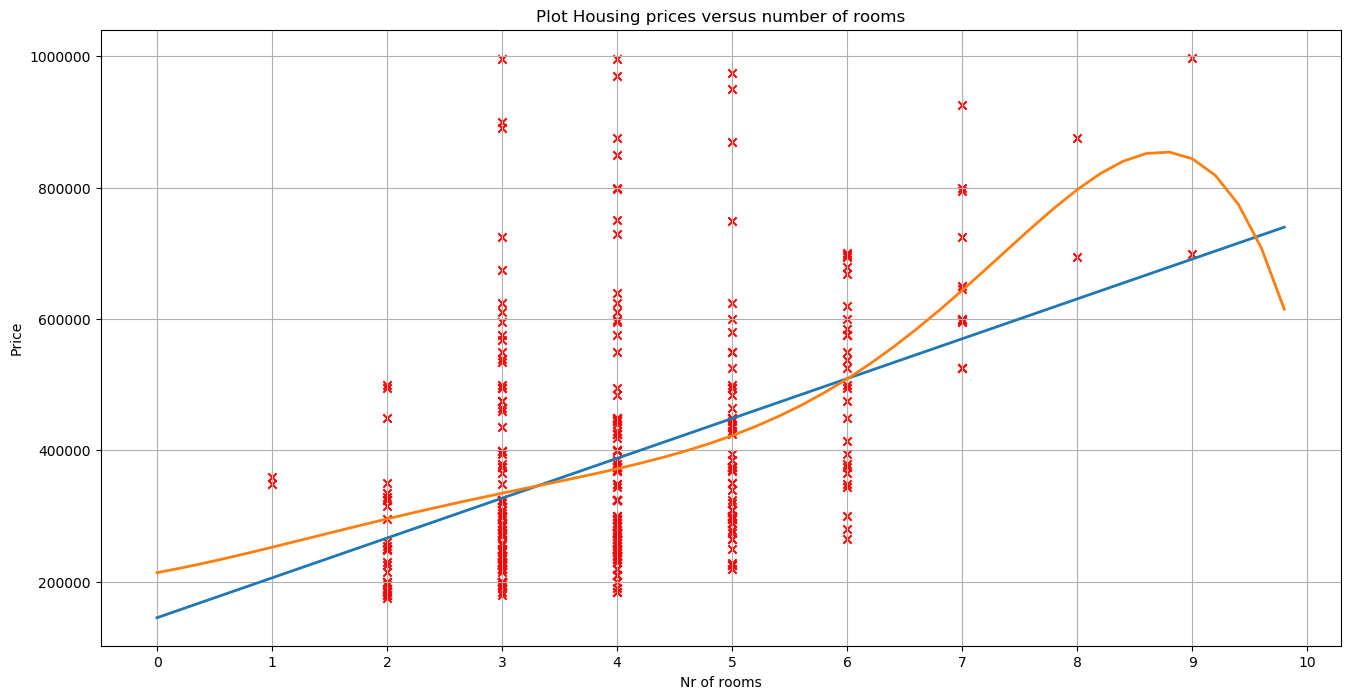

In [369]:
tick_spacing = 1
fig, ax = plt.subplots(1,1)

t = np.arange(0, 10, 0.2)
linear = predict_price_linear_num_rooms(t)
poly = predict_price_poly(t, polynomial_power, poly_model_nr)

ax.scatter(data_points_nr["x1"], data_points["y"], c='r',marker='x')
ax.plot(t, linear, lw=2)
ax.plot(t, poly, lw=2)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.title('Plot Housing prices versus number of rooms')
plt.ylabel('Price')
plt.xlabel('Nr of rooms')
plt.rcParams["figure.figsize"] = (16,8)
plt.grid()
plt.show()

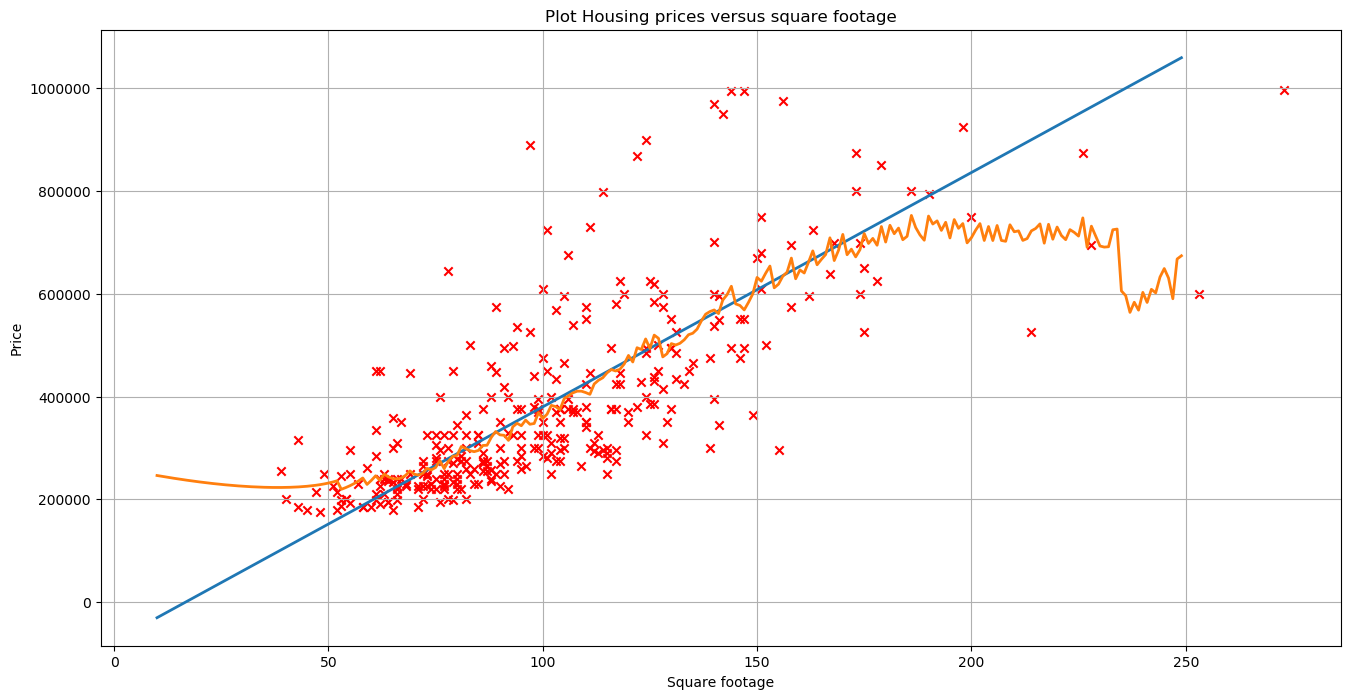

In [363]:
tick_spacing = 50
fig, ax = plt.subplots(1,1)

t = np.arange(10, 250, 1)
linear = predict_price_linear_square_footage(t)
poly = predict_price_poly(t, polynomial_power, poly_model_sf)

ax.scatter(data_points_sf["x1"], data_points["y"], c='r',marker='x')
ax.plot(t, linear, lw=2)
ax.plot(t, poly, lw=2)
plt.title('Plot Housing prices versus square footage')
plt.ylabel('Price')
plt.xlabel('Square footage')
plt.rcParams["figure.figsize"] = (16,8)
plt.grid()
plt.show()

# Back to the presentation to talk about some concepts, among them Regularisation

In [370]:
train, test = data_points_sf.random_split(.8)

In [371]:
model_no_reg = tc.linear_regression.create(train, target='y', l1_penalty=0.0, l2_penalty=0.0)
model_L1_reg = tc.linear_regression.create(train, target='y', l1_penalty=1, l2_penalty=0.0)
model_L2_reg = tc.linear_regression.create(train, target='y', l1_penalty=0.0, l2_penalty=1)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Linear regression:

--------------------------------------------------------

Number of examples          : 236

Number of features          : 20

Number of unpacked features : 20

Number of coefficients    : 21

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+

| Iteration | Passes   | Elapsed Time | Training Max Error | Validation Max Error | Training Root-Mean-Square Error | Validation Root-Mean-Square Error |

+-----------+----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+

| 1         | 2        | 0.007072     | 501812.923758      | 229857.771211        | 117159.276529                   | 98109.411794                      |

+-----------+----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+

SUCCESS: Optimal solution found.

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Linear regression:

--------------------------------------------------------

Number of examples          : 236

Number of features          : 20

Number of unpacked features : 20

Number of coefficients    : 21

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Max Error | Validation Max Error | Training Root-Mean-Square Error | Validation Root-Mean-Square Error |

+-----------+----------+-----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+

| 0         | 1        | 1.000000  | 0.003013     | 997500.000000      | 890000.000000        | 432040.164142                   | 462949.428207                     |

| 1         | 2        | 0.000301  | 0.060145     | 1006748.243977     | 722048.038247        | 227642.558247                   | 240722.504962                     |

| 2         | 3        | 0.000301  | 0.068480     | 900647.069877      | 664484.043740        | 184481.782417                   | 203303.606425                     |

| 3         | 4        | 0.000301  | 0.075461     | 565315.123537      | 621523.864523        | 154260.820220                   | 187745.758152                     |

| 4         | 5        | 0.000301  | 0.091962     | 489619.074741      | 587652.282986        | 135590.834500                   | 181032.671548                     |

| 5         | 6        | 0.000301  | 0.094755     | 462754.329943      | 561681.236695        | 125786.896536                   | 178095.185127                     |

| 10        | 11       | 0.000301  | 0.113038     | 465779.385687      | 506912.111818        | 114911.966828                   | 167829.929305                     |

+-----------+----------+-----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+

Completed (Iteration limit reached).

This model may not be optimal. To improve it, consider increasing `max_iterations`.

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Linear regression:

--------------------------------------------------------

Number of examples          : 236

Number of features          : 20

Number of unpacked features : 20

Number of coefficients    : 21

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+

| Iteration | Passes   | Elapsed Time | Training Max Error | Validation Max Error | Training Root-Mean-Square Error | Validation Root-Mean-Square Error |

+-----------+----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+

| 1         | 2        | 0.013359     | 488659.524769      | 318274.494335        | 115456.091368                   | 137160.500735                     |

+-----------+----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+

SUCCESS: Optimal solution found.

In [366]:
predicted_no_reg = model_no_reg.predict(test)
predicted_l1_reg = model_L1_reg.predict(test)
predicted_l2_reg = model_L2_reg.predict(test)

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

print("Root mean square error No regularisation: {:.0f}".format(rmse(predicted_no_reg, test["y"])))
print("Root mean square error L1 regularisation: {:.0f}".format(rmse(predicted_l1_reg, test["y"])))
print("Root mean square error L2 regularisation: {:.0f}".format(rmse(predicted_l2_reg, test["y"])))


Root mean square error No regularisation: 121211
Root mean square error L1 regularisation: 116705
Root mean square error L2 regularisation: 115654


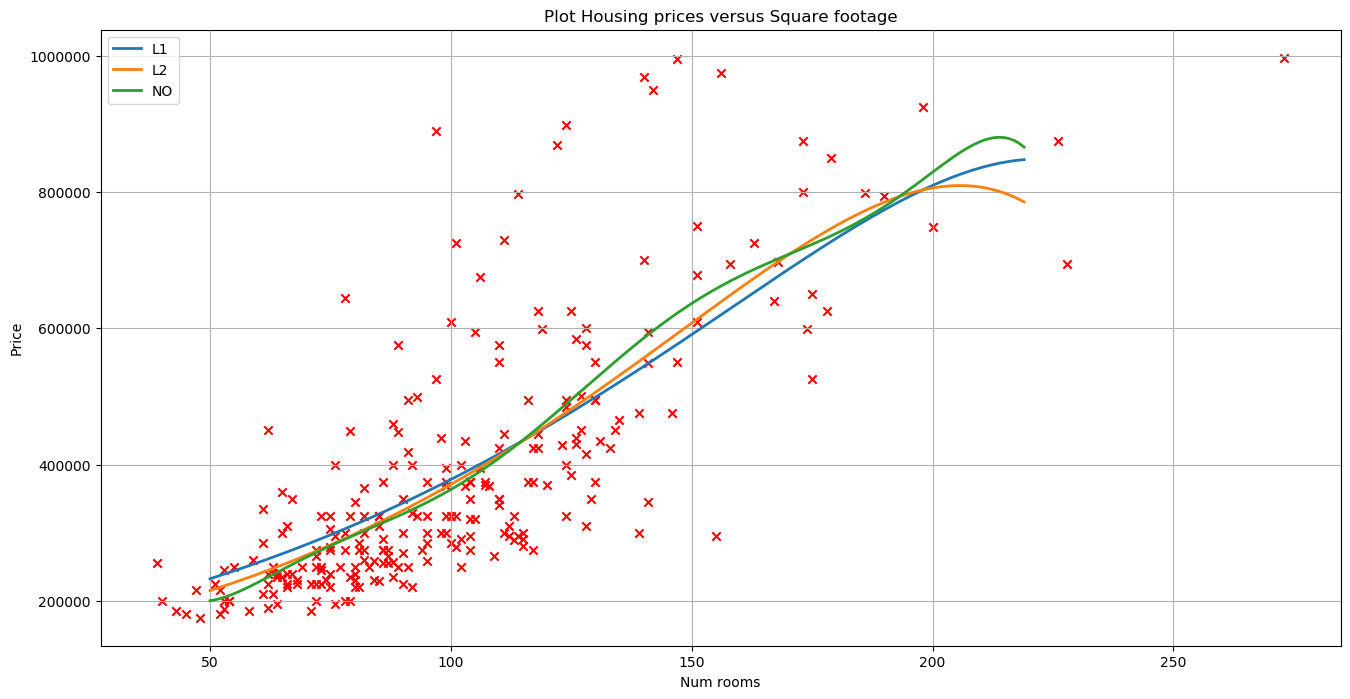

In [372]:
tick_spacing = 50
fig, ax = plt.subplots(1,1)

t = np.arange(50, 220, 1)
poly_no_reg = predict_price_poly(t, polynomial_power, model_no_reg)
poly_l1_reg = predict_price_poly(t, polynomial_power, model_L1_reg)
poly_l2_reg = predict_price_poly(t, polynomial_power, model_L2_reg)

ax.scatter(train["x1"], train["y"], c='r',marker='x')
ax.plot(t, poly_l1_reg, lw=2, label='L1')
ax.plot(t, poly_l2_reg, lw=2, label='L2')
ax.plot(t, poly_no_reg, lw=2, label='NO')
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.title('Plot Housing prices versus Square footage')
plt.ylabel('Price')
plt.xlabel('Num rooms')
# plt.rcParams["figure.figsize"] = (6,8)
plt.legend()
plt.grid()
plt.show()